# Topic Modelling by NMF
Topic modelling is a popular method to get an overview over the content of a set of documents. Imagine the documents are composed of topics and topics are described by words. Then the actual ocurrence of a word in a document should be related to the probability of the word describing a topic and the probability of the topic representing the document. Non negative matrix factorization seeks matrices related to these probabilities in order to compose the [Tfidf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) transform of the document term matrix.

Check [this](http://mlexplained.com/2017/12/28/a-practical-introduction-to-nmf-nonnegative-matrix-factorization/) for an introduction to NMF or [this](https://mimno.infosci.cornell.edu/info6150/) for course material on topic modelling.

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_20newsgroups
from sklearn import decomposition
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
%matplotlib inline
np.set_printoptions(suppress=True)

### get 20 newsgroups data
This takes very long, due to many files being created when we unpack the newsgroup data.

In [2]:
categories = None  # ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
remove = ('headers', 'footers', 'quotes')
%time newsgroups_train = fetch_20newsgroups(data_home='/tmp/', subset='train', categories=categories, remove=remove)

CPU times: user 6.27 s, sys: 1.42 s, total: 7.69 s
Wall time: 17.7 s


### vectorize and filter data

In [3]:
TOKEN_PAT = r'\b[^(\W|\d|_)]{1,}\w\w+\b'  # words starting with a proper character having at least length 3
cnt_vecr = CountVectorizer(stop_words='english', min_df=0.005, max_df=0.2, token_pattern=TOKEN_PAT)
dtm = cnt_vecr.fit_transform(newsgroups_train.data)
print('{} documents'.format(dtm.shape[0]))

MIN_WORDS = 10
good_ics = np.where((dtm > 0).sum(axis=1) >= MIN_WORDS)[0]
good_newsgroup_data = [newsgroups_train.data[i] for i in good_ics]  # no pointless docs in training
dtm = cnt_vecr.fit_transform(good_newsgroup_data)
print('{} useful documents'.format(dtm.shape[0]))

MAX_WORD_COUNT = 10
dtm[dtm > MAX_WORD_COUNT] = 10  # no pointless word counts

vectors_tfidf = TfidfTransformer().fit_transform(dtm)
vocab = cnt_vecr.get_feature_names()
P_term = dtm.sum(axis=0) / dtm.sum()
print('{} terms in vocab'.format(len(vocab)))

# This would give us the tfidf transform of the document term matrix directly
# vectorizer_tfidf = TfidfVectorizer(stop_words='english', min_df=0.001, max_df=0.5)
# vectors_tfidf = vectorizer_tfidf.fit_transform(newsgroups_train.data) # (documents, vocab)

11314 documents
8774 useful documents
2713 terms in vocab


### topic model with sklearn NMF

Sklearn NMF has several parameters. The multiplicative updates 'mu' for gradient descend are usually much faster. So is the beta_loss = 2 which refers to the euclidean norm. As we interpret the factors as something close to probability distributions, beta_loss = 1, the Kullback-Leibler divergence would has a better interpretation, but computes slower. Topic modelling is not a very sound principle anyways, so the choice doesn't matter much.

In [4]:
n_topics = 20

# beta_loss: 1 = kullback-leibler, 2 = frobenius-norm
nmf = decomposition.NMF(n_components=n_topics, random_state=1, solver='mu', beta_loss=2)

%time W1 = nmf.fit_transform(vectors_tfidf)
H1 = nmf.components_

CPU times: user 2.29 s, sys: 3.39 s, total: 5.68 s
Wall time: 1.54 s


### present topics by relevant words
- W1 has shape $n_{documents} \times n_{topics}$
- H1 has shape $n_{topics} \times n_{terms}$

We can look into topics by printing their frequent terms, but this will also bring up many frequent meaningless terms, that are not exactly stopwords, but take a similar role here. The Tfidf transform of the document term matrix was one step to mitigate the problem. Another one would be using a NLP tool like [spaCy](https://spacy.io/) to extract only nouns and verbs or only noun phrases as 'terms'. We can also use a normalization trick to improve the topic inspection.

The following function mentioned in [pyLDAvis](https://github.com/bmabey/pyLDAvis) (footnote 2, but that's misleading) is taken from https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf
- for lbd = 1 equivalent to ordering terms by rows of `topic_term_mat`
- for lbd < 1 focuses on rare words


In [5]:
def extract_topics(topic_term_mat, vocab, P_term, lbd=1, n_top_terms=12):
    regularized_topic_term_mat = np.asarray(
        lbd * np.log1p(topic_term_mat) +
        (1 - lbd) * np.log1p(np.multiply(topic_term_mat, 1 / P_term.reshape(1, -1)))
    )

    def top_words(t):
        return [(vocab[i], t[i]) for i in np.argsort(t)[:-n_top_terms-1:-1]]

    return [top_words(t) for t in regularized_topic_term_mat]


def show_topics(topic_term_mat, vocab, P_term, lbd=1, n_top_terms=12):
    topics_top_words = extract_topics(topic_term_mat, vocab, P_term, lbd=lbd, n_top_terms=n_top_terms)
    
    for top_words in topics_top_words:
        yield ' '.join([word for word, value in top_words])

#### lbd = 1

In [6]:
for i, t in enumerate(show_topics(H1, vocab, P_term, lbd=1)):
    print('{:2d}: {}'.format(i, t))

 0: time say believe did way things really make good point does said
 1: software mac problem using memory screen program run server version running modem
 2: game team games year players season play hockey win league teams nhl
 3: geb pitt cadre dsl n3jxp chastity shameful intellect skepticism surrender gordon banks
 4: government encryption clipper privacy chip law nsa clinton security secure data technology
 5: drive scsi drives hard ide disk controller floppy bus boot power motherboard
 6: key chip keys bit escrow bits serial chips clipper algorithm number des
 7: edu mail space com send list address email nasa information university internet
 8: israel armenian armenians israeli jews turkish arab war armenia turkey turks jewish
 9: card video drivers cards monitor bus vga driver ati diamond ram isa
10: windows dos microsoft file files drivers win running disk driver version font
11: thanks advance does help looking appreciated mail info anybody information need greatly
12: window 

#### lbd = 1 versus lbd = 0.4

Here compare subsequent lines. The second one picks more interesting words, that might give a better intuition about the topic.

In [7]:
for i, (t1, t2) in enumerate(zip(show_topics(H1, vocab, P_term, lbd=1),
                                 show_topics(H1, vocab, P_term, lbd=0.4))):
    print('{:2d}: {}'.format(i, t1))
    print('    {}'.format(t2))  

 0: time say believe did way things really make good point does said
    christianity atheists beliefs teachings religions bible christians scripture biblical spiritual diet gods
 1: software mac problem using memory screen program run server version running modem
    mac printer modem quadra screen memory software mouse print apple port server
 2: game team games year players season play hockey win league teams nhl
    pitching nhl hockey players team game playoffs scored coach season leafs games
 3: geb pitt cadre dsl n3jxp chastity shameful intellect skepticism surrender gordon banks
    dsl chastity n3jxp geb shameful cadre intellect skepticism pitt surrender gordon banks
 4: government encryption clipper privacy chip law nsa clinton security secure data technology
    encryption phones clipper crypto privacy wiretap nsa cellular classified government conversations secure
 5: drive scsi drives hard ide disk controller floppy bus boot power motherboard
    drive scsi ide drives flop

### sanity check of result

In [8]:
# all terms should have nonzero attributions to topics
H1.sum(axis=0).min()

0.03977917796844176

In [9]:
# all documents should have nonzero components
np.isclose(W1.sum(axis=1), 0).sum()

0

### pyLDAvis
This is an amazing tool to interactively explore a topic model. It's a d3 visualization. You have essentially 2 ways to understand you model. Click a topic and see the term distribution or click a term and see the topic distribution. The size of the topics is relative to the documents that support them. The ruler controls the lambda we used in `extract_topics`. The warnings come from pandas deprecations.

In [10]:
from sklearn.preprocessing import normalize
import pyLDAvis

def normalize_nmf_matrices(nmf_A, nmf_B):
    """
    NMF is an inverse problem with local minima, that are not even unique. You can multiply the columns of A
    and divide the rows of B with the same number, while keeping their product unchanged. The interpretation
    of B is a probability distribution over words for every row/topic. We normalize B and adapt A accordingly.
    Then we normalize the rows of A to also represent probabilities.
    """
    A = normalize(nmf_A / nmf_B.sum(axis=1, keepdims=True).T, axis=1, norm='l1')
    B = normalize(nmf_B, axis=1, norm='l1')
    return A, B

W, H = normalize_nmf_matrices(W1, H1)

doc_lengths = np.asarray(dtm.sum(axis=1)).flatten()
term_freqs = np.array(dtm.sum(axis=0)).squeeze()

lda_display = pyLDAvis.prepare(topic_term_dists=H, 
                               doc_topic_dists=W, 
                               doc_lengths=doc_lengths, 
                               vocab=vocab, 
                               term_frequency=term_freqs, 
                               sort_topics=False, mds='mmds')
pyLDAvis.display(lda_display)

/home/chris/.pyenv/versions/3.6.5/envs/work/lib/python3.6/site-packages/pyLDAvis/_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
/home/chris/.pyenv/versions/3.6.5/envs/work/lib/python3.6/site-packages/pyLDAvis/_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
/home/chris/.pyenv/versions/3.6.5/envs/work/lib/python3.6/site-packages/pyLDAvis/_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)
/home/chris/.pyenv/versions/3.6.5/envs/work/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([def

### sparseness of the solutions
Let's just have a rough view on the distribution of coefficients in W and H before and after normalizing.

- The normalization pushes W to slightly smaller coefficients, but 70 percent are zeros.
- For values of H are substantially rescaled by the normalization, hence we only look at the normalized values. Their distribution approaches 0 smoother than W, which makes it hard to tell a percentage

zero components 72.1 %


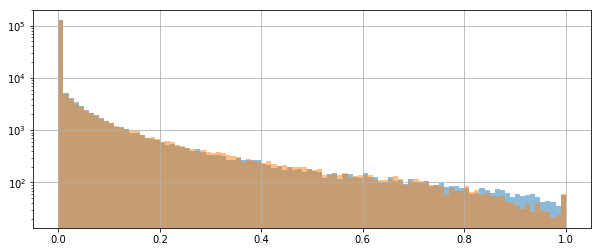

In [11]:
pd.Series(W.flatten()).hist(bins=100, log=True, alpha=0.5, figsize=(10,4))
pd.Series(normalize(W1, axis=1, norm='l1').flatten()).hist(log=True, bins=100, alpha=0.5)
print('zero components {:4.1f} %'.format(100 * np.sum(W < 0.01) / np.prod(W.shape)))

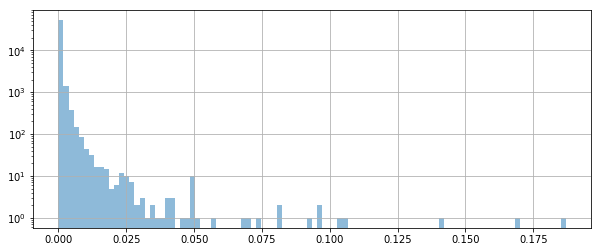

In [12]:
pd.Series(H.flatten()).hist(bins=100, log=True, alpha=0.5, figsize=(10,4))

### fancy topic visualization
We can create wordclouds, using the term weights computed above in `extract_topics`.

In [13]:
from wordcloud import WordCloud
from PIL import Image

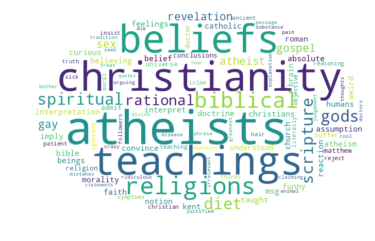

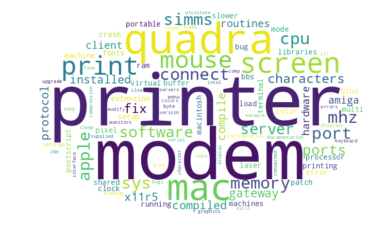

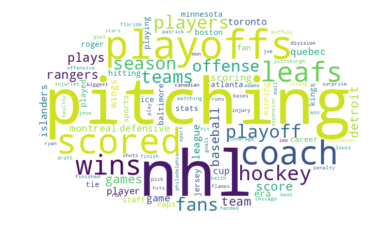

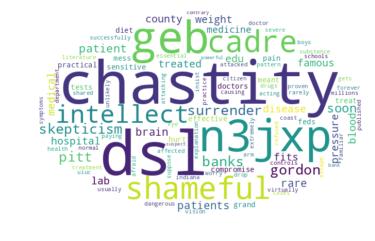

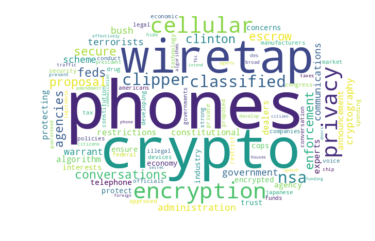

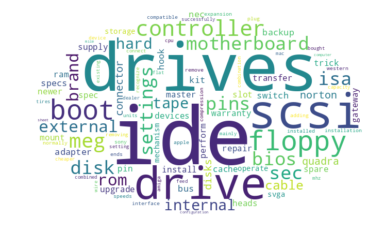

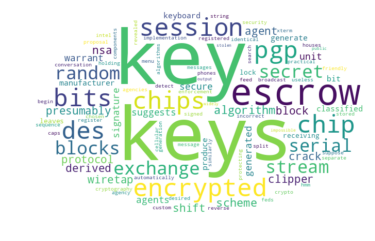

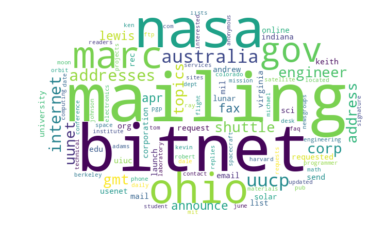

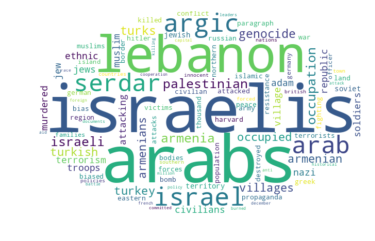

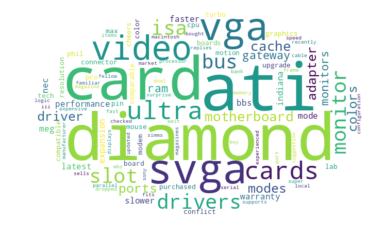

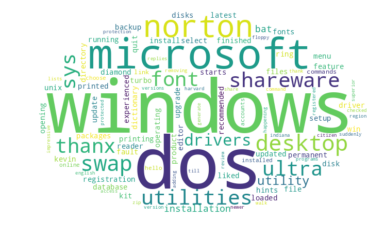

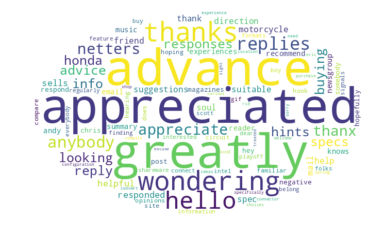

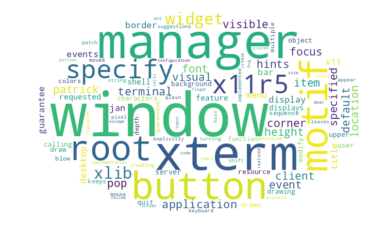

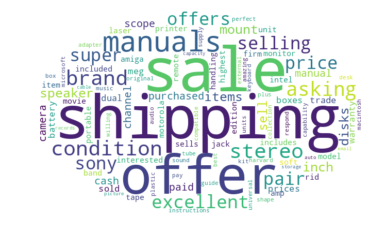

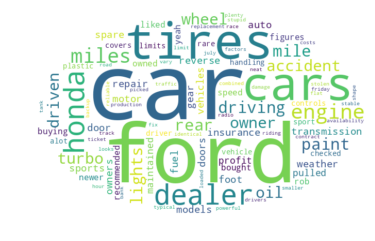

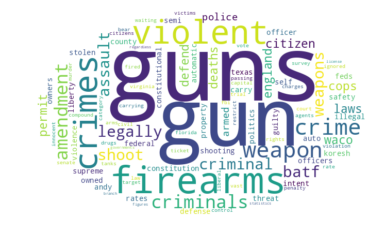

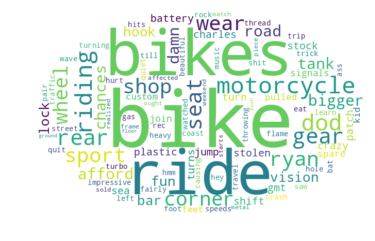

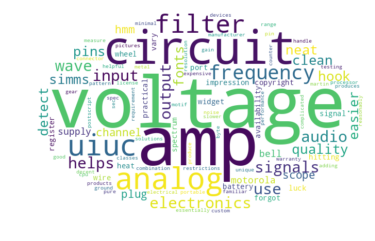

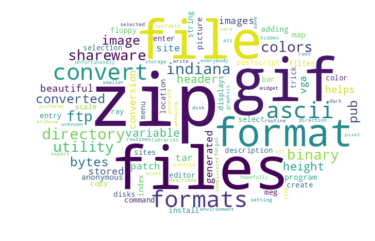

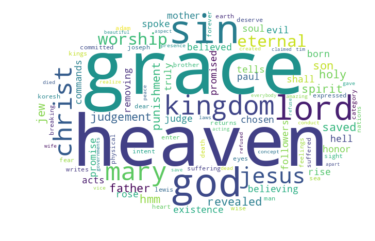

In [14]:
def makeImage(freq_dct, mask):

    # generate word cloud
    wc = WordCloud(background_color="white", max_words=200, mask=mask)
    wc.generate_from_frequencies(freq_dct)

    # show
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

# load mask
mask = np.array(Image.open("ellipse.png"))

topic_top_terms = extract_topics(H, vocab, P_term, lbd=0.4, n_top_terms=100)

for i, term_pairs in enumerate(topic_top_terms):
    makeImage(dict(term_pairs), mask)